# Model comparisons

In this notebook, we'll take BartPy through its paces using increasingly complex sin wave models.  We'll compare how it performs to two similar models: OLS and catboost.

For the purposes of this exercise, I'm testing out of the box performance.  This makes sense, as part of the value prop of BartPy is it's ability to work well without parameter tuning, but it's possible that the scores of all of the models could be improved with parameter tuning

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel

%matplotlib inline

## Set up models

In [3]:
def fit_catboost(X_train, y_train, X_test, y_test):
    eval_cutoff = len(X_train) // 3
    eval_X, eval_y, train_X, train_y = X_train[:eval_cutoff, :], y_train[:eval_cutoff], X_train[eval_cutoff:, :], y_train[eval_cutoff:]
    catboost_model = catboost.CatBoostRegressor()
    catboost_model.fit(Pool(train_X, train_y), eval_set = Pool(eval_X, eval_y), use_best_model=True)
    pred = catboost_model.predict(X_test)
    score = r2_score(y_test, pred)
    return catboost_model, pred, score

def fit_bartpy(X_train, y_train, X_test, y_test):
    model = SklearnModel(n_samples=1000, n_burn=50, n_trees=500, store_in_sample_predictions=False)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return model, pred, score

def fit_linear_model(X_train, y_train, X_test, y_test):
    rebased_x = np.sin(X_train[:, 0]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(rebased_x, y_train)
    pred = linear_model.predict(np.sin(X_test[:, 0]).reshape(-1, 1))
    score = linear_model.score(np.sin(X_test[:, 0]).reshape(-1, 1), y_test)
    return linear_model, pred, score

kf = KFold(2)

def compare_models(X, y, models_funcs = [fit_bartpy, fit_catboost, fit_linear_model]):
    scores, predictions, trained_models = [], [], []

    for train_index, test_index in kf.split(X):
        trained_models.append([])    
        scores.append([])
        predictions.append([])

        for f in models_funcs:
            model, pred, score = f(X[train_index, :], y[train_index], X[test_index, :], y[test_index])
            trained_models[-1].append(deepcopy(model))
            predictions[-1].append(pred)
            scores[-1].append(score)
    return scores, predictions, trained_models

## One dimensional, single wave

Text(0.5, 1.0, 'X v y')

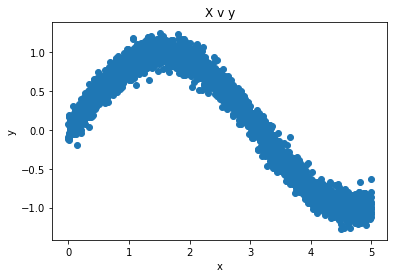

In [4]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [5]:
scores, predictions, models = compare_models(X, y, [fit_bartpy])

KeyboardInterrupt: 

In [36]:
scores

NameError: name 'scores' is not defined

In [0]:
scores, predictions, trained_models = compare_models(X, y)

**As we might expect, all three models are capable of capturing such a simple function.  There's very little difference between the scores or predictions of the models.**

In [0]:
scores

In [0]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

In [0]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

## Single dimension - multiple waves

** To extend our original model, let's add a high frequency cosine wave in our single dimension.  This will make the predicted function change faster and at varying rates across x **

In [0]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [0]:
scores, predictions, trained_models = compare_models(X, y)

** Catboost and BartPy capture this faster moving sin wave pretty nicely, and come up with very similar predictions.  The linear model pretty much treats the cos wave as noise, and fits a curve close to the original one **

In [0]:
scores

In [0]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

In [0]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

In [0]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Single dimension - discrete break points

** To make the model more complex, let's add some discrete dumps to make the curve less smooth.  This will test the ability of the models to handle very isolated effects in feature space **

In [0]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
y[(X[:,0] < 1.5) & (X[:,0] > 1.)] += 3
y[(X[:,0] < 3.5) & (X[:,0] > 3.)] -= 3
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [0]:
scores, predictions, trained_models = compare_models(X, y)

In [0]:
scores

In [0]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

In [0]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

In [0]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

# Single meaningful dimension - additional noise dimensions

** It's important for the models to be able to correctly identify features that aren't important.  In this case, we just add normally distributed noise features.  This shouldn't be too difficult a problem to solve **

In [0]:
x = np.linspace(0, 5, 3000)
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [0]:
scores, predictions, trained_models = compare_models(X, y)

In [0]:
scores

In [0]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

In [0]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

In [0]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Mixture of multiple meaningful dimensions and noise dimensions

** Both catboost and BartPy have performed well with noise dimensions and rapidly moving targets, let's combine them to make a relatively difficult test for tree models **

In [0]:
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.sin(5 * X[:, 1]) + np.cos(-6 * X[:, 3])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 3], y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")


In [0]:
scores, predictions, trained_models = compare_models(X, y, [fit_bartpy])

In [0]:
scores

In [0]:
scores

In [0]:
#plt.scatter(X[:1500,3],predictions[0][1], label = "Bart")
#plt.scatter(X[:1500,3],predictions[0][2], label = "Ols")
plt.scatter(X[:1500,3],predictions[0][0], label = "Catboost")
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")
plt.legend(loc = "best")

In [0]:
plt.scatter(y[:1500],predictions[0][0], label = "Catboost")
#plt.scatter(y[:1500],predictions[0][1], label = "Catboost")
#plt.scatter(y[:1500],predictions[0][2], label = "Catboost")

In [0]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)